# gather and format data

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import h5py
import timeit

df = pd.read_csv('sensor_stand_1_clean.csv')
df.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow = pd.read_csv('flow_stand_1_clean.csv')
flow.columns = ['Flow']

In [5]:
def scaleFlow(flow):
    
    flow_scaled = []
    
    for i in range(0, len(flow)):
        
        flow_scaled.append((flow['Flow'][i] - min(flow['Flow'])) / (max(flow['Flow']) - min(flow['Flow'])))
        
    return pd.DataFrame(flow_scaled, columns = ['Flow'])

def movingAvg(Class, windowSize):
    """
    Create moving average to remove single outliers

    Args:
        Class (list): List of inhale / exhale classes
        Windowsize (int): Size of moving average window

    Returns:
        filteredClass (list): Filtered list of classes
    """
    
    filteredClass = []
    for i in range(0, len(Class)):

        if i < windowSize - 1:
            filteredClass.append(Class[i])

        elif Class[i] != Class[i - 1]:
            if sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize > 1:
                filteredClass.append(2)

            elif sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize < 1:
                filteredClass.append(0)

            else:
                filteredClass.append(Class[i])

        elif Class[i] == Class[i - 1]:
            filteredClass.append(Class[i])
            
    return filteredClass

def classSwitch(Class):
    """
    Class switch function to filter 3 classifiers down to 2 (inhale and exhale)

    Args:
        Class (list): List of inhale / exhale classes

    Returns:
        decisionClass (list): Filtered (with moving average) of resulting simplified class
    """

    decision = []
    for i in range(0, len(Class)):
        
        if Class[i] == 1:
            decision.append(1)
            
        elif Class[i] == 0:
            decision.append(0)
            
        elif Class[i] == 2:
            if len(decision) > 1:
                decision.append(decision[-1])
            else:
                decision.append(2)
            
    return movingAvg(decision, 3)

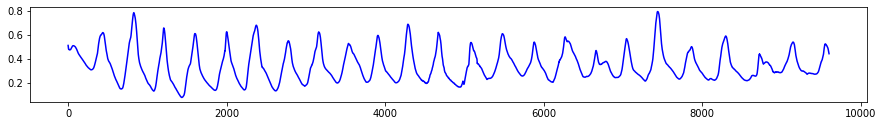

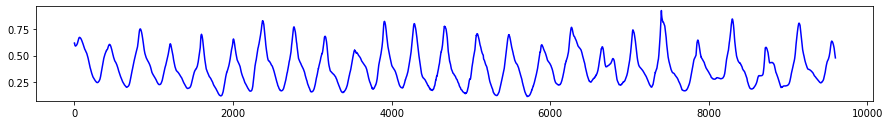

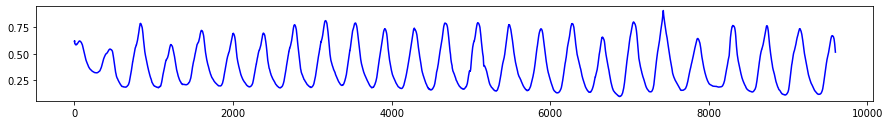

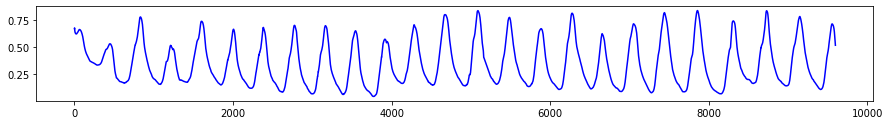

In [6]:
x = range(0, len(df))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.plot(x, df['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.plot(x, df['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.plot(x, df['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.plot(x, df['4'], 'b')
plt.show()

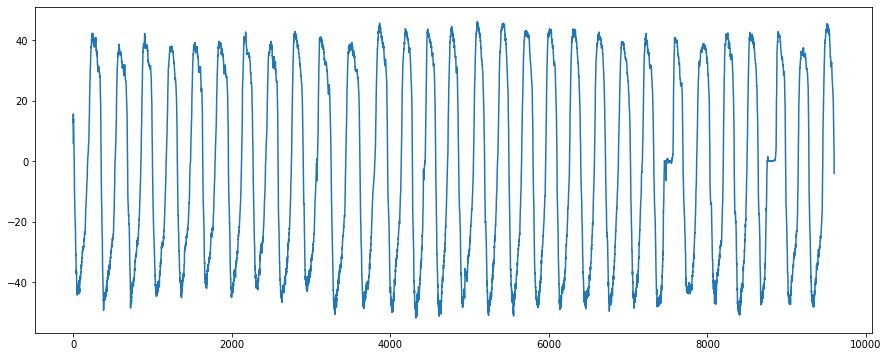

In [511]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow['Flow'])

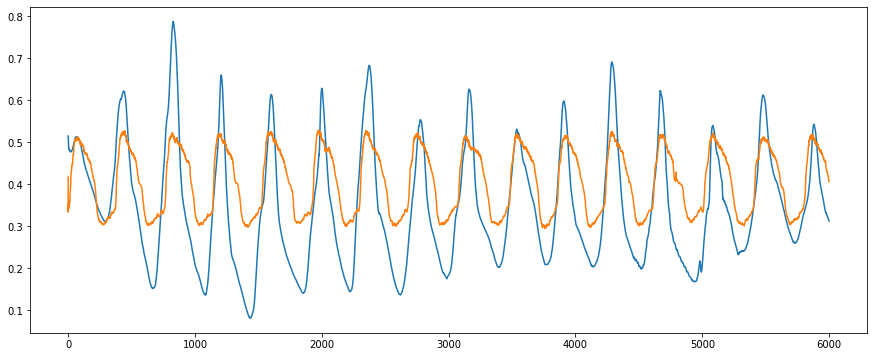

In [7]:
x = range(0, len(df['4'][0:6000]))
flow['a'] = (flow['Flow'] / 400) - 0.4
fig = plt.figure(figsize = (15, 6))
plt.plot(x, df['1'][0:6000], x, flow['a'][0:6000]*-1)

In [543]:
flow.drop('a', inplace = True, axis = 1)

In [544]:
def classLabel(label):
    if label < -5:
        return 0
    elif label > 5:
        return 1
    else:
        return 2

df['Class'] = flow['Flow'].apply(classLabel)

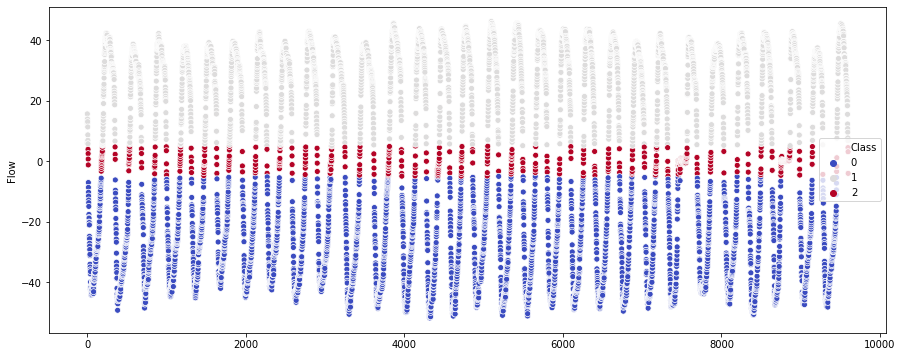

In [545]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow['Flow'], x = range(0, len(flow)), hue = df['Class'], palette = 'coolwarm')

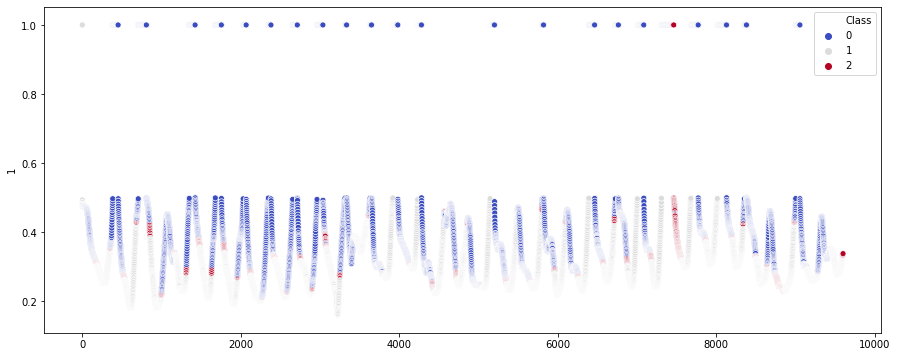

In [546]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df['1'], x = range(0, len(df)), hue = df['Class'], palette = 'coolwarm')

In [547]:
# Create the data matrix
X = df.drop('Class', axis = 1)
X.drop('hours', inplace = True, axis = 1)
X.drop('minutes', inplace = True, axis = 1)
X.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
y = df['Class']
y = pd.DataFrame(y, index = None, columns = ['Class'])

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)

# model training - random forest

In [548]:
print(" Random Forest ... ")

start = timeit.default_timer()
classifier = RandomForestClassifier(n_estimators = 100)
rf_model = classifier.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
end = timeit.default_timer()

print(" accuracy = ", accuracy_score(y_test, predictions), " time = ", end - start)
print(confusion_matrix(y_test, predictions))
print("\n")

print("Random Forest")
print(classification_report(y_test, predictions))

 Random Forest ... 


/Users/mikefurr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


 accuracy =  0.9725694444444445  time =  0.6907773740003904
[[1440    3   14]
 [  19 1212    5]
 [  19   19  149]]


Random Forest
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1457
           1       0.98      0.98      0.98      1236
           2       0.89      0.80      0.84       187

    accuracy                           0.97      2880
   macro avg       0.95      0.92      0.93      2880
weighted avg       0.97      0.97      0.97      2880



In [549]:
Predictions = classSwitch(predictions)
Class = classSwitch(list(y_test['Class']))
print('Random Forest - Decision')
print("\n")
print(classification_report(Class, Predictions))

Random Forest - Decision


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2228
           1       0.97      0.95      0.96       652

    accuracy                           0.98      2880
   macro avg       0.98      0.97      0.97      2880
weighted avg       0.98      0.98      0.98      2880



# model testing on new data

In [550]:
df_test = pd.read_csv('sensor_stand_1_clean.csv')
df_test.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']
flow_test = pd.read_csv('flow_stand_1_clean.csv')
flow_test.columns = ['Flow']

In [551]:
df_test['Class'] = flow_test['Flow'].apply(classLabel)

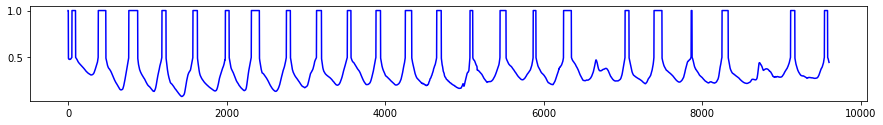

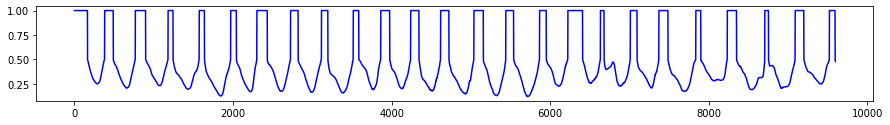

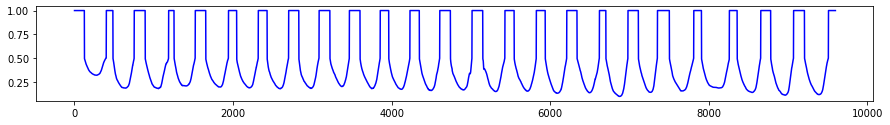

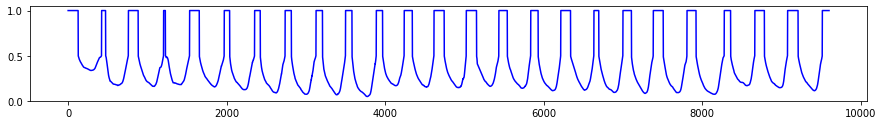

In [555]:
x = range(0, len(df_test))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)

plt.plot(x, df_test['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.plot(x, df_test['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.plot(x, df_test['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.plot(x, df_test['4'], 'b')
plt.show()

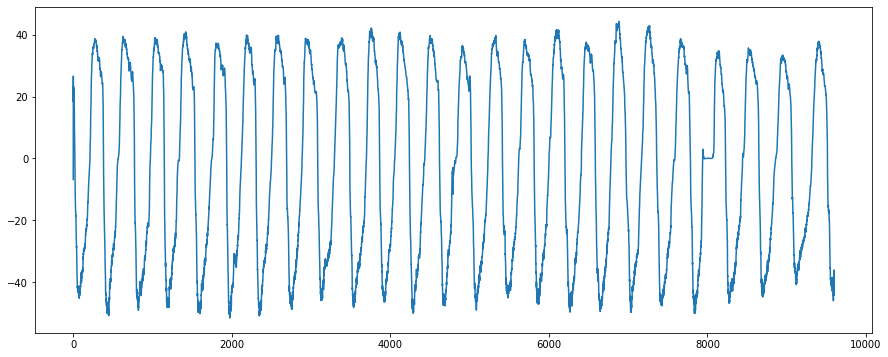

In [556]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow_test['Flow'])

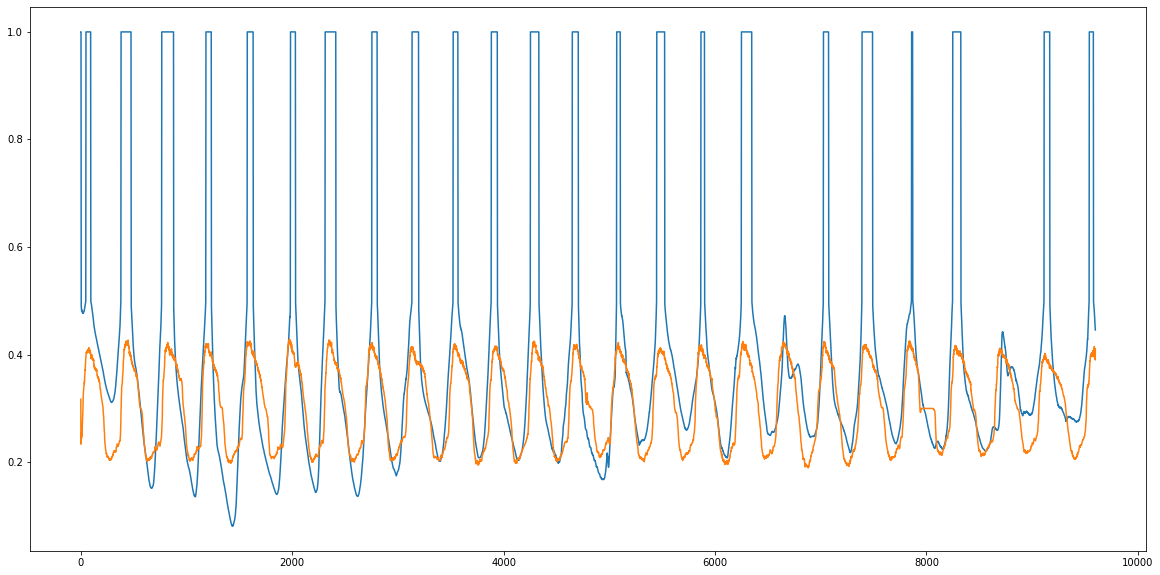

In [557]:
flow_test['a'] = (flow_test['Flow'] / 400) - 0.3
fig = plt.figure(figsize = (20, 10))
plt.plot(x, df_test['1'], x, flow_test['a']*-1)

In [558]:
flow_test.drop('a', inplace = True, axis = 1)

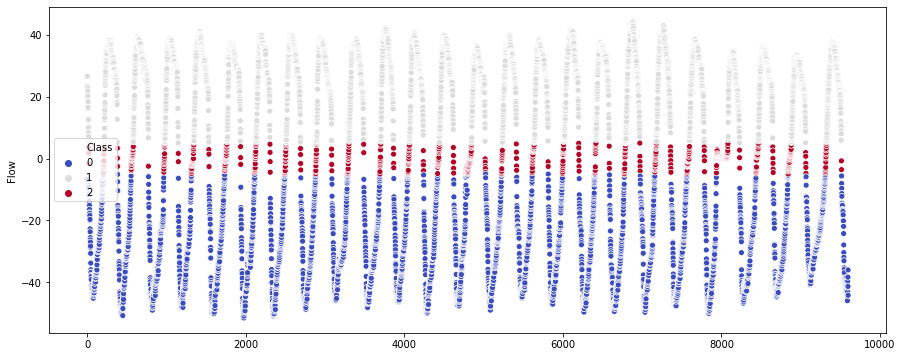

In [559]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'], x = range(0, len(flow_test)), hue = df_test['Class'], palette = 'coolwarm')

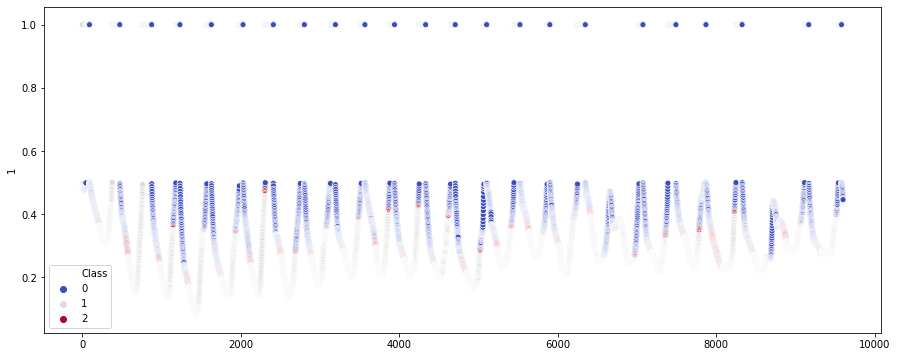

In [560]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df_test['1'], x = range(0, len(df_test)), hue = df_test['Class'], palette = 'coolwarm')

In [561]:
test_sensors = df_test.drop('Class', axis = 1)
test_sensors.drop('hours', inplace = True, axis = 1)
test_sensors.drop('minutes', inplace = True, axis = 1)
test_sensors.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
test_class = df_test['Class']
test_class = pd.DataFrame(test_class, index = None, columns = ['Class'])

# model testing - random forest

In [562]:
test_predictions = rf_model.predict(test_sensors)
print(" accuracy = ", accuracy_score(test_class, test_predictions))
print(confusion_matrix(test_class, test_predictions))
print("\n")

print('Random Forest - Testing')
print('\n')
print(classification_report(test_class, test_predictions))

 accuracy =  0.8123762891967913
[[4113  457   28]
 [ 544 3678   34]
 [ 301  437    7]]


Random Forest - Testing


              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4598
           1       0.80      0.86      0.83      4256
           2       0.10      0.01      0.02       745

    accuracy                           0.81      9599
   macro avg       0.58      0.59      0.57      9599
weighted avg       0.76      0.81      0.78      9599



In [563]:
testPredictions = classSwitch(test_predictions)
testClass = classSwitch(list(test_class['Class']))
print('Random Forest - Testing')
print('\n')
print(" accuracy = ", accuracy_score(testClass, testPredictions))
print(classification_report(testClass, testPredictions))

Random Forest - Testing


 accuracy =  0.8487342431503282
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      5271
           1       0.82      0.85      0.84      4328

    accuracy                           0.85      9599
   macro avg       0.85      0.85      0.85      9599
weighted avg       0.85      0.85      0.85      9599



In [531]:
score = []

for i in range(0, len(testPredictions)):
    
    score.append(testPredictions[i] == testClass[i])

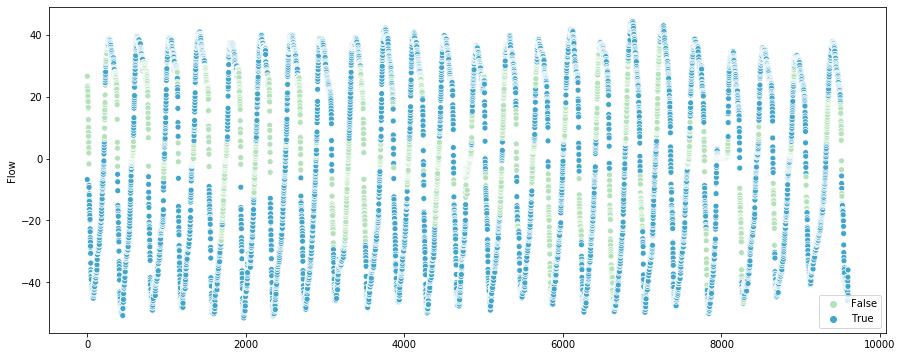

In [532]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'], x = range(0, len(flow_test['Flow'])), hue = score, palette = 'GnBu')